<a href="https://colab.research.google.com/github/Lee-Gunju/Lee-Gunju/blob/master/assignment_10_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

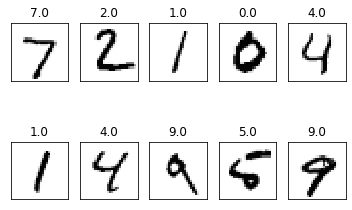

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import csv

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

def normal(image):
  image = (image - min(image)) / (max(image) - min(image))
  return image

size_row, size_col, image_num = 28, 28, len(data)
image_vec = np.empty((image_num, size_row * size_col))
label_vec = np.empty(image_num)
cnt = -1

for i in data:
  cnt += 1
  delete_dot = i.split(',') 
  label_vec[cnt] = delete_dot[0]
  delete_dot = np.asfarray(delete_dot)
  image_vec[cnt] = delete_dot[1:]
  image_vec[cnt] = normal(image_vec[cnt])

plt.figure()
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.title(label_vec[i])
  plt.imshow(image_vec[i].reshape((size_col, size_row)), cmap = 'Greys', interpolation='None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()

def one_hot(label, mid):
  num = len(label)
  one_hot_label = np.zeros((num, 10)) + 0.01
  cnt = -1
  for i in label:
    cnt += 1
    one_hot_label[cnt][int(i)] = 0.99
  return one_hot_label[:mid], one_hot_label[mid:]

def mapping(image, label, mid):
  train_X, test_X = image[:mid], image[mid:, :]
  train_Y, test_Y = one_hot(label, mid)
  return train_X, train_Y, test_X, test_Y

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

class NeuralNetwork():
  def __init__(self):
    self.lr = 0.1
    self.decay = 0.6
    self.w1 = np.random.randn(784, 400)
    self.b1 = np.zeros(self.w1.shape[1])
    self.w2 = np.random.randn(self.w1.shape[1], 80)
    self.b2 = np.zeros(self.w2.shape[1])
    self.w3 = np.random.randn(self.w2.shape[1], 10)
    self.b3 = np.zeros(self.w3.shape[1])
    self.n = (self.w1.shape[0] * self.w1.shape[1]) + (self.w2.shape[0] * self.w2.shape[1]) + (self.w3.shape[0] * self.w3.shape[1])

  def forward(self, input):
    x = np.dot(input, self.w1) + self.b1
    self.X = sigmoid(x)
    y = np.dot(self.X, self.w2) + self.b2
    self.Y = sigmoid(y)
    z = np.dot(self.Y, self.w3) + self.b3
    self.Z = sigmoid(z)

  def backpropa(self, input, output):
    temp = output - self.Z
    self.w3 += self.lr * ((np.dot(self.Y.T, temp)) + ((self.decay / self.n) * self.w3))
    self.b3 += self.lr * np.sum(temp, axis = 0)
    temp = np.dot(temp, self.w3.T)
    temp = np.multiply(temp, np.multiply(self.Y, (1.0 - self.Y)))
    self.w2 += self.lr * ((np.dot(self.X.T, temp)) + ((self.decay / self.n) * self.w2))
    self.b2 += self.lr * np.sum(temp, axis = 0)
    temp = np.dot(temp, self.w2.T)
    temp = np.multiply(temp, np.multiply(self.X, (1.0 - self.X)))
    self.w1 += self.lr * ((np.dot(input.T, temp)) + ((self.decay / self.n) * self.w1))
    self.b1 += self.lr * np.sum(temp, axis = 0)
  
  def objective(self, l, h, m):
    #n = (self.w1.shape[0] * self.w1.shape[1]) + (self.w2.shape[0] * self.w2.shape[1]) + (self.w3.shape[0] * self.w3.shape[1])
    J = np.sum(np.multiply(-l, np.log(h)) - np.multiply((1-h), np.log(1-h))) / m
    J += (self.decay / (2*self.n)) * ((np.sum(np.square(self.w1))) + (np.sum(np.square(self.w2))) + (np.sum(np.square(self.w3))))
    return J


  def train(self, input, output):
    input = np.array(input, ndmin = 2)
    output = np.array(output, ndmin = 2)
    self.forward(input)
    self.backpropa(input, output)
  
  def predict(self, input):
    self.forward(input)
    return self.Z
  
  def test(self, input, output):
    T, F = 0, 0
    self.forward(input)
    for i in range(len(input)):
      result = self.Z[i].argmax()
      if result == int(output[i]):
        T += 1
      else:
        F += 1
    return T / (T + F)
  
  def classification(self, input, output):
    T_i, F_i, T_l, F_l = [], [], [], []
    for i in range(len(input)):
      result = self.predict(input[i])
      result_max = result.argmax()
      if result_max == output[i]:
        T_i.append(input[i])
        T_l.append(result_max)
      else:
        F_i.append(input[i])
        F_l.append(result_max)
      if len(T_l) >= 10 and len(F_l) >= 10:
        return T_i, F_i, T_l, F_l



In [34]:
mid = int(image_num * 0.1)
train_X, train_Y, test_X, test_Y = mapping(image_vec, label_vec, mid)
train_target = label_vec[:mid]
test_target = label_vec[mid:]

model = NeuralNetwork()
epoch = 100
train_plot_J, train_plot_Acc, test_plot_J, test_plot_Acc = [], [], [], []

for i in range(epoch):
  print(i + 1)
  for j in range(mid):
    model.train(train_X[j], train_Y[j])
  train_J = model.objective(train_Y, model.predict(train_X), image_num)
  train_Acc = model.test(train_X, train_target)
  train_plot_J.append(train_J)
  train_plot_Acc.append(train_Acc)

  test_J = model.objective(test_Y, model.predict(test_X), image_num)
  test_Acc = model.test(test_X, test_target)
  print(test_Acc)
  test_plot_J.append(test_J)
  test_plot_Acc.append(test_Acc)

T_images, F_images, T_label, F_label = model.classification(test_X, test_target)

1
0.4776666666666667
2
0.5428888888888889
3
0.5833333333333334
4
0.6157777777777778
5
0.6897777777777778
6
0.7237777777777777
7
0.771
8
0.7355555555555555
9
0.7361111111111112
10
0.7806666666666666
11
0.8188888888888889
12
0.8256666666666667
13
0.8241111111111111
14
0.8265555555555556
15
0.8263333333333334
16
0.825
17
0.8256666666666667
18
0.8252222222222222
19
0.8254444444444444
20
0.8263333333333334
21
0.8266666666666667
22
0.8261111111111111
23
0.8267777777777777
24
0.8254444444444444
25
0.8253333333333334
26
0.8258888888888889
27
0.8242222222222222
28
0.8232222222222222
29
0.8227777777777778
30
0.8235555555555556
31
0.8235555555555556
32
0.8237777777777778
33
0.8231111111111111
34
0.8227777777777778
35
0.8231111111111111
36
0.8226666666666667
37
0.8225555555555556
38
0.8218888888888889
39
0.8223333333333334
40
0.8228888888888889
41
0.8225555555555556
42
0.8211111111111111
43
0.822
44
0.8212222222222222
45
0.8205555555555556
46
0.8201111111111111
47
0.8198888888888889
48
0.819555555

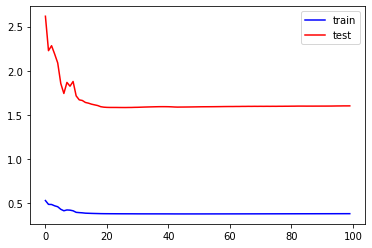

In [35]:
# 1. Plot the loss curve
plt.figure()
plt.plot(train_plot_J, 'b', label = 'train')
plt.plot(test_plot_J, 'r', label = 'test')
plt.legend()
plt.show()

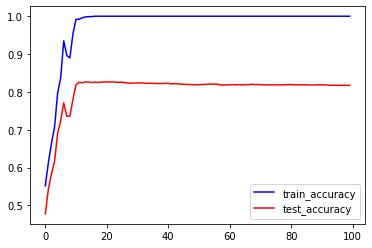

In [36]:
# 2. Plot the accuracy curve
plt.figure()
plt.plot(train_plot_Acc, 'b', label = 'train_accuracy')
plt.plot(test_plot_Acc, 'r', label = 'test_accuracy')
plt.legend()
plt.show()

In [37]:
# 3. Plot the accuracy value
print("Final train accuracy : ", train_plot_Acc[len(train_plot_Acc) - 1] * 100)
print("Final test accuracy : ", test_plot_Acc[len(test_plot_Acc) - 1] * 100)

Final train accuracy :  100.0
Final test accuracy :  81.72222222222221


Classified Testing Images


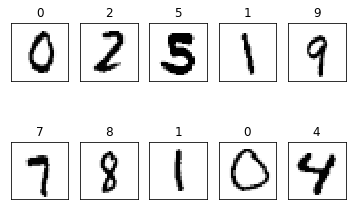




 Misclassified Test Images


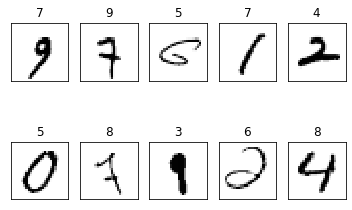

In [38]:
# 4. Plot the classification example

print('Classified Testing Images')
plt.figure()
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.title(T_label[i])
  plt.imshow(T_images[i].reshape((size_col, size_row)), cmap = 'Greys', interpolation = 'None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()

print('\n\n\n Misclassified Test Images')
plt.figure()
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.title(F_label[i])
  plt.imshow(F_images[i].reshape((size_col, size_row)), cmap = 'Greys', interpolation = 'None')
  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()

In [39]:
# 5. Testing accuracy [20pt]
test_plot_Acc.sort(reverse = True)
for i, values in enumerate(test_plot_Acc):
  print(i+1, ":", values)

1 : 0.8267777777777777
2 : 0.8266666666666667
3 : 0.8265555555555556
4 : 0.8263333333333334
5 : 0.8263333333333334
6 : 0.8261111111111111
7 : 0.8258888888888889
8 : 0.8256666666666667
9 : 0.8256666666666667
10 : 0.8254444444444444
11 : 0.8254444444444444
12 : 0.8253333333333334
13 : 0.8252222222222222
14 : 0.825
15 : 0.8242222222222222
16 : 0.8241111111111111
17 : 0.8237777777777778
18 : 0.8235555555555556
19 : 0.8235555555555556
20 : 0.8232222222222222
21 : 0.8231111111111111
22 : 0.8231111111111111
23 : 0.8228888888888889
24 : 0.8227777777777778
25 : 0.8227777777777778
26 : 0.8226666666666667
27 : 0.8225555555555556
28 : 0.8225555555555556
29 : 0.8223333333333334
30 : 0.822
31 : 0.8218888888888889
32 : 0.8212222222222222
33 : 0.8211111111111111
34 : 0.8206666666666667
35 : 0.8205555555555556
36 : 0.8205555555555556
37 : 0.8204444444444444
38 : 0.8202222222222222
39 : 0.8201111111111111
40 : 0.8201111111111111
41 : 0.8198888888888889
42 : 0.8198888888888889
43 : 0.8197777777777778
44 